<img src = "https://github.com/singlestore-labs/spaces-notebooks/blob/e551e274bb67bb1e5081131ee1150cdba713fc43/common/images/singlestore-jupyter.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Movie Recommender Part 2</h1>
    </div>
</div>

In [2]:
!pip cache purge --quiet

In [3]:
!pip install matplotlib --quiet
!pip install wordcloud --quiet

# Download Data

In [4]:
import requests
import zipfile
import io
import urllib3

In [5]:
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def download_and_extract_zip(url, extract_to, verify = True):
    response = requests.get(url, verify = verify)
    if response.status_code == 200:
        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            z.extractall(extract_to)
        print(f"Zip file from '{url}' downloaded and unpacked successfully to '{extract_to}'")
    else:
        print(f"Failed to download the zip file from '{url}'")

urls = [
    "https://github.com/babu-thomas/movielens-posters/files/3513037/ml-1m.zip",
    # Backup "https://github.com/VeryFatBoy/workshop/raw/main/posters/ml-1m.zip",
    "https://files.grouplens.org/datasets/movielens/ml-1m.zip"
    # Backup "https://github.com/VeryFatBoy/workshop/raw/main/datasets/ml-1m.zip"
]

extract_dirs = [
    "posters",
    "datasets"
]

for url, extract_dir in zip(urls, extract_dirs):
    verify = not url.startswith("https://files.grouplens.org")
    download_and_extract_zip(url, extract_dir, verify)

Zip file from 'https://github.com/babu-thomas/movielens-posters/files/3513037/ml-1m.zip' downloaded and unpacked successfully to 'posters'
Zip file from 'https://files.grouplens.org/datasets/movielens/ml-1m.zip' downloaded and unpacked successfully to 'datasets'


# Read Data

## Read Movies Data

In [6]:
import pandas as pd

In [7]:
movies_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/movies.dat",
    engine = "python",
    sep = "::",
    header = None,
    encoding = "latin1",
    names = ["id", "title", "genres"]
)

In [8]:
movies_df.head()

,id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


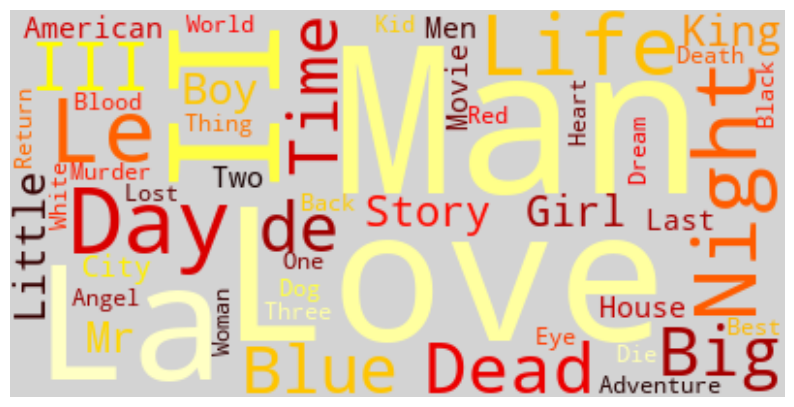

In [9]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

movie_titles_list = movies_df["title"].tolist()
movie_titles_corpus = " ".join(movie_titles_list)

wordcloud = WordCloud(
    stopwords = STOPWORDS,
    background_color = "lightgrey",
    colormap = "hot",
    max_words = 50,
    # collocations = False
).generate(movie_titles_corpus)

plt.figure(figsize = (10, 8))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

## Read Movie Posters Data

In [10]:
posters_df = pd.read_csv(
    f"{extract_dirs[0]}/ml-1m/movie_poster.csv",
    header = None,
    names = ["id", "poster"]
)

In [11]:
posters_df.head()

,id,poster
0,1,https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,2,https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,3,https://m.media-amazon.com/images/M/MV5BMjQxM2...
3,4,https://m.media-amazon.com/images/M/MV5BYzcyMD...
4,5,https://m.media-amazon.com/images/M/MV5BOTEyNz...


## Merge Posters with Movies

In [12]:
movies_df = pd.merge(
    movies_df,
    posters_df,
    on = "id",
    how = "left"
)

In [13]:
generic_link = "https://placehold.co/100x150.jpg"

movies_df["poster"] = movies_df["poster"].fillna(generic_link)

In [14]:
movies_df.head()

,id,title,genres,poster
0,1,Toy Story (1995),Animation|Children's|Comedy,https://m.media-amazon.com/images/M/MV5BMDU2ZW...
1,2,Jumanji (1995),Adventure|Children's|Fantasy,https://m.media-amazon.com/images/M/MV5BZTk2Zm...
2,3,Grumpier Old Men (1995),Comedy|Romance,https://m.media-amazon.com/images/M/MV5BMjQxM2...
3,4,Waiting to Exhale (1995),Comedy|Drama,https://m.media-amazon.com/images/M/MV5BYzcyMD...
4,5,Father of the Bride Part II (1995),Comedy,https://m.media-amazon.com/images/M/MV5BOTEyNz...


## Read Users Data

In [15]:
users_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/users.dat",
    engine = "python",
    sep = "::",
    header = None,
    encoding = "latin1",
    names = ["id", "gender", "age", "occupation_id", "zip_code"]
)

In [16]:
users_df.head()

,id,gender,age,occupation_id,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [17]:
result = (
    users_df.groupby("gender")
    .size()
    .reset_index(name = "count")
)

print(result.to_string(index = False))

gender  count
     F   1709
     M   4331


## Merge Occupations with Users

In [18]:
occupations = [
    ( 0, "other"),
    ( 1, "academic/educator"),
    ( 2, "artist"),
    ( 3, "clerical/admin"),
    ( 4, "college/grad student"),
    ( 5, "customer service"),
    ( 6, "doctor/health care"),
    ( 7, "executive/managerial"),
    ( 8, "farmer"),
    ( 9, "homemaker"),
    (10, "K-12 student"),
    (11, "lawyer"),
    (12, "programmer"),
    (13, "retired"),
    (14, "sales/marketing"),
    (15, "scientist"),
    (16, "self-employed"),
    (17, "technician/engineer"),
    (18, "tradesman/craftsman"),
    (19, "unemployed"),
    (20, "writer")
]

columns = ["occupation_id", "occupation"]

occupations_df = pd.DataFrame(occupations, columns = columns)

print(occupations_df.to_string(index = False))

 occupation_id           occupation
             0                other
             1    academic/educator
             2               artist
             3       clerical/admin
             4 college/grad student
             5     customer service
             6   doctor/health care
             7 executive/managerial
             8               farmer
             9            homemaker
            10         K-12 student
            11               lawyer
            12           programmer
            13              retired
            14      sales/marketing
            15            scientist
            16        self-employed
            17  technician/engineer
            18  tradesman/craftsman
            19           unemployed
            20               writer


In [19]:
users_df = pd.merge(
    users_df,
    occupations_df,
    on = "occupation_id",
    how = "left"
)

In [20]:
users_df.drop("occupation_id", axis = 1, inplace = True)

In [21]:
users_df.head()

,id,gender,age,zip_code,occupation
0,1,F,1,48067,K-12 student
1,2,M,56,70072,self-employed
2,3,M,25,55117,scientist
3,4,M,45,02460,executive/managerial
4,5,M,25,55455,writer


In [22]:
result = (
    users_df.groupby("occupation")
    .size()
    .reset_index(name = "count")
    .sort_values(by = "count", ascending = False)
    .head(21)
)

print(result.to_string(index = False))

          occupation  count
college/grad student    759
               other    711
executive/managerial    679
   academic/educator    528
 technician/engineer    502
          programmer    388
     sales/marketing    302
              writer    281
              artist    267
       self-employed    241
  doctor/health care    236
        K-12 student    195
      clerical/admin    173
           scientist    144
             retired    142
              lawyer    129
    customer service    112
           homemaker     92
          unemployed     72
 tradesman/craftsman     70
              farmer     17


## Read Ratings Data

In [23]:
ratings_df = pd.read_csv(
    f"{extract_dirs[1]}/ml-1m/ratings.dat",
    engine = "python",
    sep = "::",
    header = None,
    encoding = "latin1",
    names = ["user_id", "movie_id", "rating", "timestamp"]
)

In [24]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [25]:
result = ratings_df[["user_id", "movie_id", "rating"]].describe()
print(result.applymap(lambda x: f"{x:.2f}"))

          user_id    movie_id      rating
count  1000209.00  1000209.00  1000209.00
mean      3024.51     1865.54        3.58
std       1728.41     1096.04        1.12
min          1.00        1.00        1.00
25%       1506.00     1030.00        3.00
50%       3070.00     1835.00        4.00
75%       4476.00     2770.00        4.00
max       6040.00     3952.00        5.00


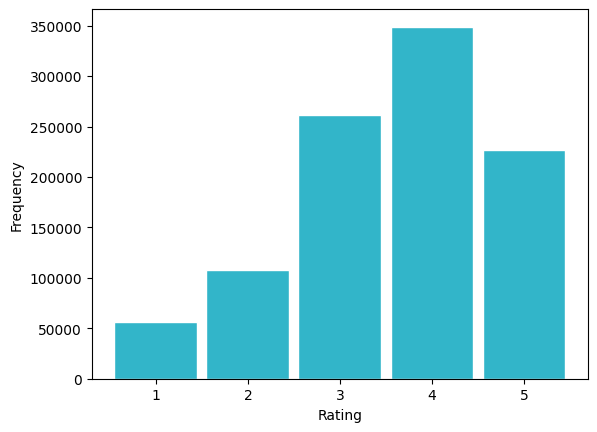

In [26]:
import matplotlib.pyplot as plt

ratings_df["rating"].plot.hist(
    edgecolor = "white",
    color = "#32B5C9",
    rwidth = 0.9,
    bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]
)

plt.ylabel("Frequency")
plt.xlabel("Rating")
plt.show()

# Write Data

In [27]:
movies_df.to_csv(
    f"{extract_dirs[1]}/ml-1m/movies.csv",
    index = False
)

users_df.to_csv(
    f"{extract_dirs[1]}/ml-1m/users.csv",
    index = False
)

ratings_df.to_csv(
    f"{extract_dirs[1]}/ml-1m/ratings.csv",
    index = False
)